# Q learning vs Double Q-learning

In [155]:
# imports 
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

from windy_gridworld import WindyGridworldEnv

In [156]:
env = WindyGridworldEnv()

In [157]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, len(self.Q[obs]))
        else:
            action = np.argmax(self.Q[obs])
        return action
    
class EpsilonGreedyPolicyDoubleQ(object):
    """
    A simple epsilon greedy policy, taking average over the two Q functions.
    Q [state, 2, action]
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, len(self.Q[obs, 0]))
        else:
            action = np.argmax(self.Q[obs][0] + self.Q[obs][1])
        return action

In [158]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

In [159]:
def q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        # convert tuple s to corresponding int if necessary
        if isinstance(s, tuple):
            int_s = 0
            temp = 1
            space_coeff = [1]
            for x in env.observation_space.spaces[:-1]:
                space_coeff.append(x.n*space_coeff[-1])
            s = sum([y*x for x, y in zip(s, space_coeff)])
            
        while True:
            a = policy.sample_action(s)
            s_new, r, done, info = env.step(a)
            if isinstance(s_new, tuple):
                s_new = sum([y*x for x, y in zip(s_new, space_coeff)])
            Q[s, a] += alpha * (r + discount_factor * np.max(Q[s_new]) - Q[s, a])
            s = s_new
            
            i += 1
            R += r
            if done == True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)



In [160]:
def double_q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function [states, 2, actions]
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        if isinstance(s, tuple):
            space_coeff = [1]
            for x in env.observation_space.spaces[:-1]:
                space_coeff.append(x.n*space_coeff[-1])                
            #s_shape = [x.n for x in env.observation_space.spaces]
            #for j in len(s_shape):
            #    int_s += s[j] * s_shape[j]
            #    temp *= s_shape[j]
            s = sum([y*x for x, y in zip(s, space_coeff)])

        while True:
            a = policy.sample_action(s)
            s_new, r, done, info = env.step(a)
            if isinstance(s_new, tuple):
                s_new = sum([y*x for x, y in zip(s_new, space_coeff)])
            # flip coin, choose Q function
            c = int(np.random.rand() < 0.5)
            max_a = np.argmax(Q[s_new, c])
            Q[s, c, a] += alpha * (r + discount_factor * Q[s_new, (c-1)**2 , max_a] - Q[s, c, a])
            s = s_new
            
            i += 1
            R += r
            if done == True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)


# Environments

## 1. Windy Gridworld


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1844.35it/s]

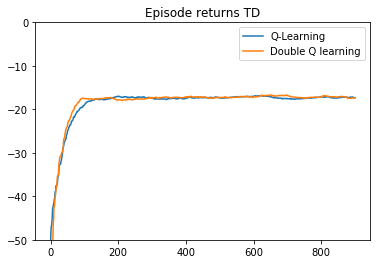

In [204]:
env = WindyGridworldEnv()

Q = np.zeros((env.nS, env.nA))
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 1000)

Q = np.zeros((env.nS, 2, env.nA))
policy = EpsilonGreedyPolicyDoubleQ(Q, epsilon=0.1)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, 1000)

def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

n = 100
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_double_q_learning, n))
plt.title('Episode returns TD')
plt.legend(['Q-Learning', 'Double Q learning'])
plt.gca().set_ylim([-50, 0])
plt.show()

## 2. Blackjack


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 11689.31it/s]

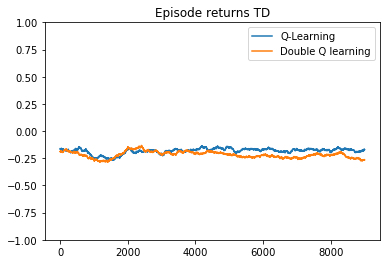

In [162]:
env = gym.make('Blackjack-v0')
# single q
Q = np.zeros([env.observation_space.spaces[0].n * env.observation_space.spaces[1].n * env.observation_space.spaces[2].n, env.action_space.n])
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 10000)

# double q
Q = np.zeros(([env.observation_space.spaces[0].n * env.observation_space.spaces[1].n * env.observation_space.spaces[2].n, 2, env.action_space.n]))
policy = EpsilonGreedyPolicyDoubleQ(Q, epsilon=0.1)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, 10000)

n = 1000
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_double_q_learning, n))
plt.title('Episode returns TD')
plt.legend(['Q-Learning', 'Double Q learning'])
plt.gca().set_ylim([-1, 1])
plt.show()


## 3. 

In [ ]:
env = gym.make('Roulette-v0')
# single q
Q = np.zeros([env.observation_space.n, env.action_space.n])
policy = EpsilonGreedyPolicy(Q, epsilon=0.1)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy, Q, 100000, alpha=0.01)
print(Q_q_learning)
# double q
Q = np.zeros(([env.observation_space.n, 2, env.action_space.n]))
policy = EpsilonGreedyPolicyDoubleQ(Q, epsilon=0.1)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy, Q, 100000, alpha=0.01)
print(Q_double_q_learning)
n = 1000
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_double_q_learning, n))
plt.title('Episode returns TD')
plt.legend(['Q-Learning', 'Double Q learning'])
plt.gca().set_ylim([-10, 10])
plt.show()



  0%|                                                | 0/100000 [00:00<?, ?it/s]

[[0.09163381 0.28279061 0.24463916 0.15825038 0.22110957 0.2048574
  0.21793498 0.19240024 0.15313264 0.19218999 0.21319093 0.25791998
  0.25797359 0.23934975 0.25901056 0.23539621 0.110139   0.2571754
  0.21866254 0.26580862 0.15597902 0.21402594 0.14521292 0.26214359
  0.27041582 0.26716855 0.30862009 0.26766961 0.26020485 0.24391765
  0.25921556 0.28576235 0.24725548 0.25756841 0.15672335 0.20657796
  0.30672865 0.31215667]]



  8%|██▉                                | 8349/100000 [00:06<01:24, 1089.78it/s]

In [212]:

def multiple_runs(env, Q, num_episodes, num_seeds, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    returns = []
    lengths = []
    for i in range(num_seeds):
        np.random.seed(i)
        Q_init = np.copy(Q)
        if len(Q.shape) == 3:
            policy = EpsilonGreedyPolicyDoubleQ(Q_init, epsilon=alpha)
            Q_trained, (episode_lengths, episode_returns) = double_q_learning(env, policy, Q_init, num_episodes, discount_factor=discount_factor, alpha=alpha)
        else:
            policy = EpsilonGreedyPolicy(Q_init, epsilon=alpha)
            Q_trained, (episode_lengths, episode_returns) = q_learning(env, policy, Q_init, num_episodes, discount_factor=discount_factor, alpha=alpha)
        returns.append(episode_returns)
        lengths.append(episode_returns)
    return np.array(lengths), np.array(returns)

def plot_mean_std(X, n, label):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    plt.plot(running_mean(mu, n), label=label)
    plt.fill_between(np.arange(len(running_mean(mu, n))), running_mean(mu+sigma, n), running_mean(mu-sigma, n), alpha=0.5)

            
        
    


  0%|                                                  | 0/1000 [00:00<?, ?it/s]


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 887.94it/s]

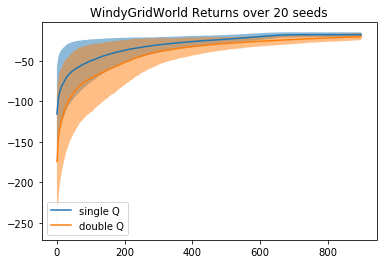

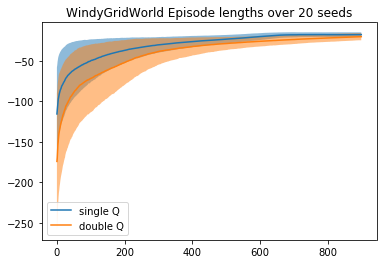

In [215]:
env = WindyGridworldEnv()
# single q init
Q_init_single = np.zeros((env.nS, env.nA))
# double q init
Q_init_double = np.zeros((env.nS, 2, env.nA))

num_seeds = 20
num_episodes = 1000
single_q_lengths, single_q_returns = multiple_runs(env, Q_init_single, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)
double_q_lengths, double_q_returns = multiple_runs(env, Q_init_double, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)

plt.title(f'WindyGridWorld Returns over {num_seeds} seeds')
plot_mean_std(single_q_returns, 100, "single Q")
plot_mean_std(double_q_returns, 100, "double Q")
plt.legend()
plt.show()

plt.title(f'WindyGridWorld Episode lengths over {num_seeds} seeds')
plot_mean_std(single_q_lengths, 100, "single Q")
plot_mean_std(double_q_lengths, 100, "double Q")
plt.legend()
plt.show()



100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1403.09it/s]

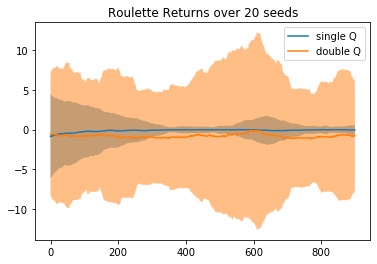

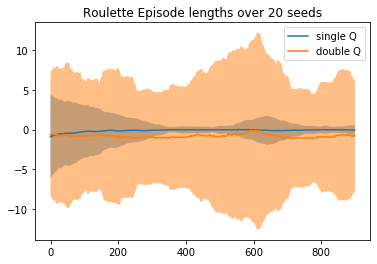

In [216]:
env = gym.make('Roulette-v0')
# single q init
Q_init_single = np.zeros([env.observation_space.n, env.action_space.n])
# double q init
Q_init_double = np.zeros(([env.observation_space.n, 2, env.action_space.n]))

num_seeds = 20
num_episodes = 1000
single_q_lengths, single_q_returns = multiple_runs(env, Q_init_single, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)
double_q_lengths, double_q_returns = multiple_runs(env, Q_init_double, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)

plt.title(f'Roulette Returns over {num_seeds} seeds')
plot_mean_std(single_q_returns, 100, "single Q")
plot_mean_std(double_q_returns, 100, "double Q")
plt.legend()
plt.show()

plt.title(f'Roulette Episode lengths over {num_seeds} seeds')
plot_mean_std(single_q_lengths, 100, "single Q")
plot_mean_std(double_q_lengths, 100, "double Q")
plt.legend()
plt.show()
